In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from gower import gower_matrix
from mpl_toolkits.mplot3d import Axes3D  
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans

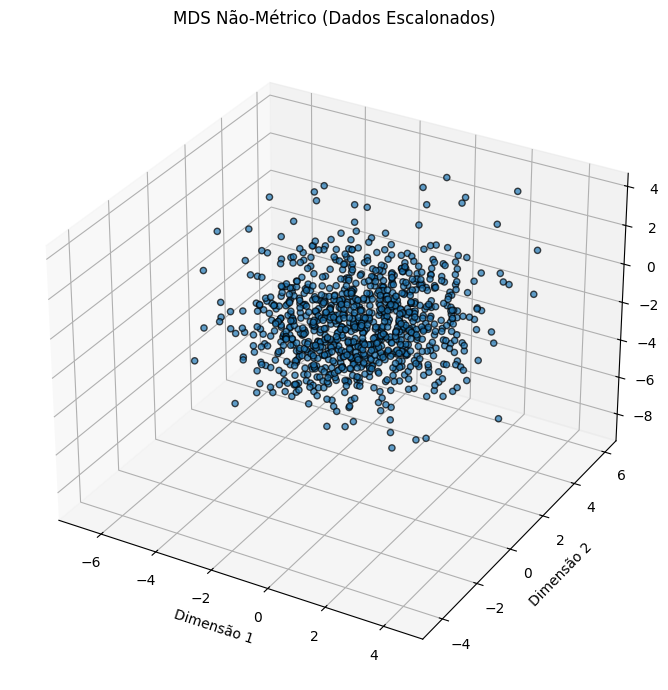

Stress final: 194399.8583


In [30]:
# Leitura do dataset
df = pd.read_csv("coronarias_drop.csv", sep=';')

# Seleção das colunas
colunas_quantitativas = ['IDADE1', 'ALTURA', 'PESO', 'IMC', 'PSR', 'PDR', 'COL' ,'TRIG']
colunas_categoricas = ['SEXO', 'DIAB', 'AH3', 'ANGEST', 'ARTER', 'ARRIT', 'OBESO', 'TABAG4', 'INFARTO','GLO']

# Subconjunto e remoção de missing
df_sub = df[colunas_quantitativas + colunas_categoricas].dropna()

scaler = StandardScaler()
df_quant_scaled = scaler.fit_transform(df_sub[colunas_quantitativas])
# --------------------------------------------------

# 2. Distância Euclidiana baseada nos dados escalonados
dist_euclidiana = pairwise_distances(df_quant_scaled, metric='euclidean')

# 3. MDS não-métrico
mds_nao_metrico = MDS(
    n_components=3,
    metric=True,
    dissimilarity='precomputed',
    normalized_stress='auto',
    random_state=42,
    n_init=5
)

config_nao_metrica = mds_nao_metrico.fit_transform(dist_euclidiana)

# 4. Plot 3D
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    config_nao_metrica[:, 0],
    config_nao_metrica[:, 1],
    config_nao_metrica[:, 2],
    edgecolors='k',
    alpha=0.7 # Adicionado para melhor visualização da densidade
)

ax.set_xlabel('Dimensão 1')
ax.set_ylabel('Dimensão 2')
ax.set_zlabel('Dimensão 3')
ax.set_title("MDS Não-Métrico (Dados Escalonados)")

plt.tight_layout()
plt.show()

print(f"Stress final: {mds_nao_metrico.stress_:.4f}")

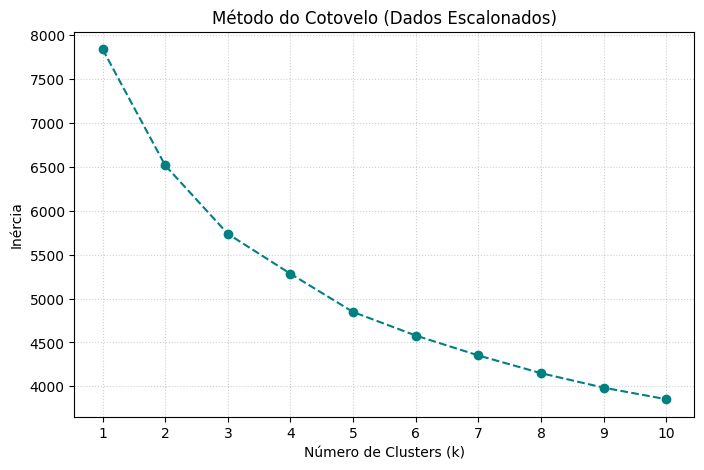

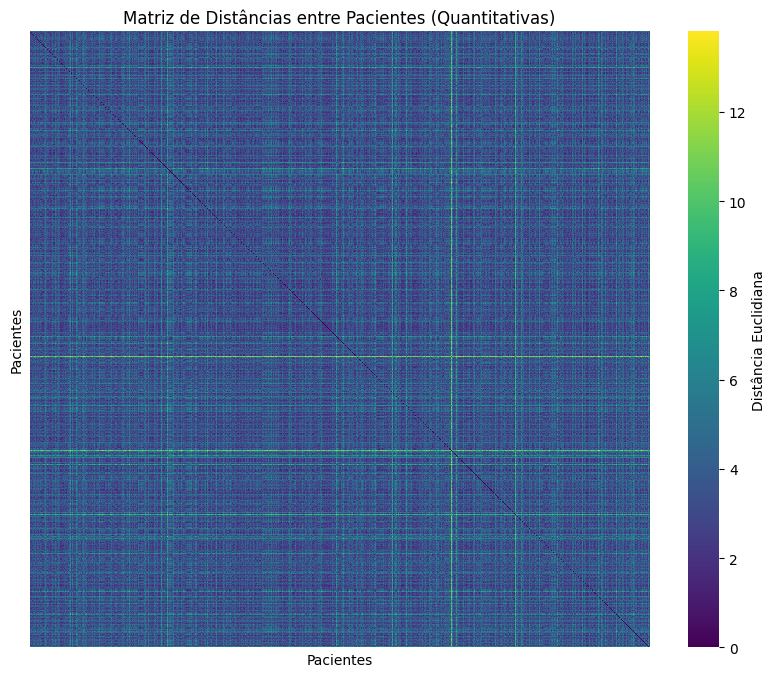

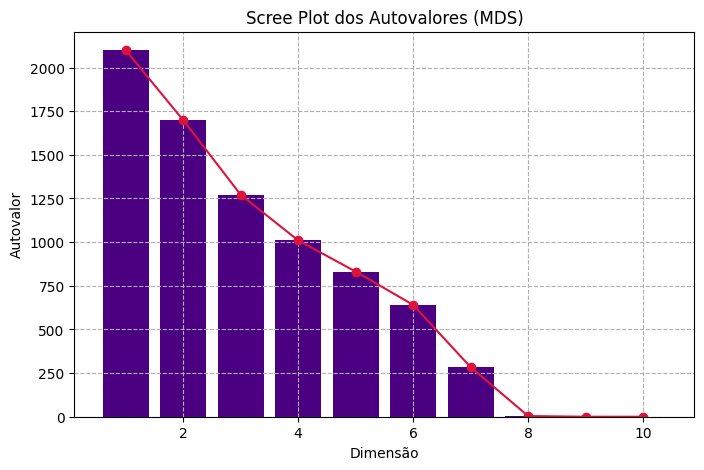

In [31]:
import plotly.express as px
from sklearn.cluster import KMeans

inertia = []
k_range = range(1, 11)

# Loop para testar diferentes números de clusters (baseado nos dados escalonados)
# df_quant_scaled deve ser o output do seu StandardScaler()
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(df_quant_scaled) 
    inertia.append(km.inertia_)

# Plotagem do Gráfico do Cotovelo
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--', color='teal')
plt.title('Método do Cotovelo (Dados Escalonados)')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.xticks(k_range)
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

# 1. Calculando os clusters (k=3 conforme discutido)
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(config_nao_metrica)

# 2. Preparando o DataFrame para o plot
df_plot = df_sub.copy()
df_plot['x'] = config_nao_metrica[:,0]
df_plot['y'] = config_nao_metrica[:,1]
df_plot['z'] = config_nao_metrica[:,2]
df_plot['Cluster'] = labels.astype(str) # Convertendo para string para o plotly tratar como categoria

# 3. Criando o gráfico colorido com hover
# 'hover_data' permite exibir os valores das quantitativas nos pontos
fig = px.scatter_3d(
    df_plot,
    x='x', y='y', z='z',
    color='Cluster',               # Cores baseadas nos 3 clusters
    opacity=0.8,
    hover_data=df_sub.columns,    # Exibe todas as quantitativas ao passar o mouse
    color_discrete_sequence=px.colors.qualitative.Bold # Esquema de cores vibrante
)

# Ajustando tamanho dos pontos
fig.update_traces(marker=dict(size=3))

fig.update_layout(
    title=f"MDS Colorido por Cluster (Stress={stress:.4f})",
    legend_title="Cluster"
)

fig.show()
import seaborn as sns

# 2. Plotar o Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    dist_euclidiana, 
    cmap='viridis',       # Cores: roxo (perto) a amarelo (longe)
    xticklabels=False,    # Remove labels para não poluir
    yticklabels=False,
    cbar_kws={'label': 'Distância Euclidiana'}
)

plt.title('Matriz de Distâncias entre Pacientes (Quantitativas)')
plt.xlabel('Pacientes')
plt.ylabel('Pacientes')
plt.show()

# 1. Transformar a matriz de distâncias para o espaço escalar (Double Centering)
def double_center(dist_matrix):
    n = dist_matrix.shape[0]
    J = np.eye(n) - np.ones((n, n)) / n
    B = -0.5 * J.dot(dist_matrix**2).dot(J)
    return B

B = double_center(dist_euclidiana)

# 2. Calcular os autovalores de B
eigenvalues, _ = np.linalg.eigh(B)

# 3. Ordenar do maior para o menor
eigenvalues = sorted(eigenvalues, reverse=True)

# 4. Plotar o Scree Plot
plt.figure(figsize=(8, 5))
plt.bar(range(1, 11), eigenvalues[:10], color='indigo') # Mostra os 10 primeiros
plt.plot(range(1, 11), eigenvalues[:10], marker='o', color='crimson')
plt.title('Scree Plot dos Autovalores (MDS)')
plt.xlabel('Dimensão')
plt.ylabel('Autovalor')
plt.grid(True, linestyle='--')
plt.show()

Tabela Consolidada de Variáveis Categóricas por Cluster (%):


,SEXO_0,SEXO_1,DIAB_0.0,DIAB_1.0,AH3_0,AH3_1,AH3_2,ANGEST_0,ANGEST_1,ARTER_0.0,...,OBESO_0.0,OBESO_1.0,TABAG4_0.0,TABAG4_1.0,TABAG4_2.0,TABAG4_3.0,INFARTO_0,INFARTO_1,GLO_0,GLO_1
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.36,0.64,0.80,0.20,0.40,0.30,0.30,0.56,0.44,0.86,...,0.82,0.18,0.50,0.13,0.21,0.16,0.74,0.26,0.29,0.71
1,0.35,0.65,0.82,0.18,0.41,0.27,0.32,0.61,0.39,0.88,...,0.98,0.02,0.44,0.17,0.23,0.15,0.67,0.33,0.33,0.67
2,0.07,0.93,0.83,0.17,0.40,0.29,0.31,0.60,0.40,0.90,...,0.86,0.14,0.25,0.19,0.22,0.34,0.61,0.39,0.31,0.69


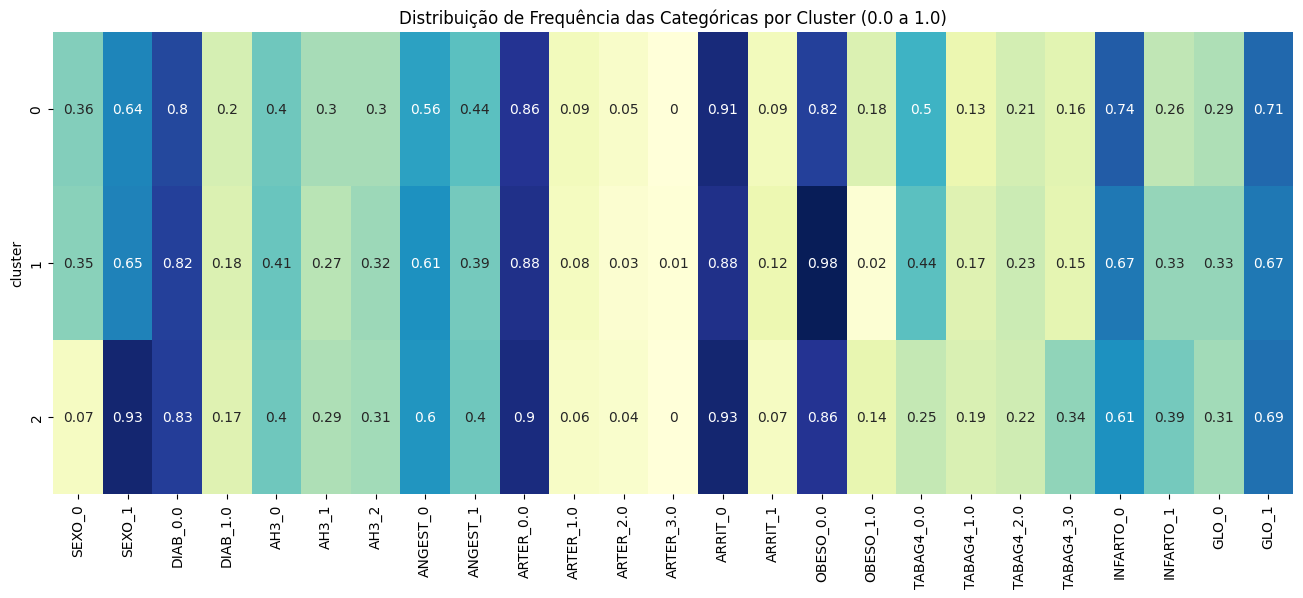

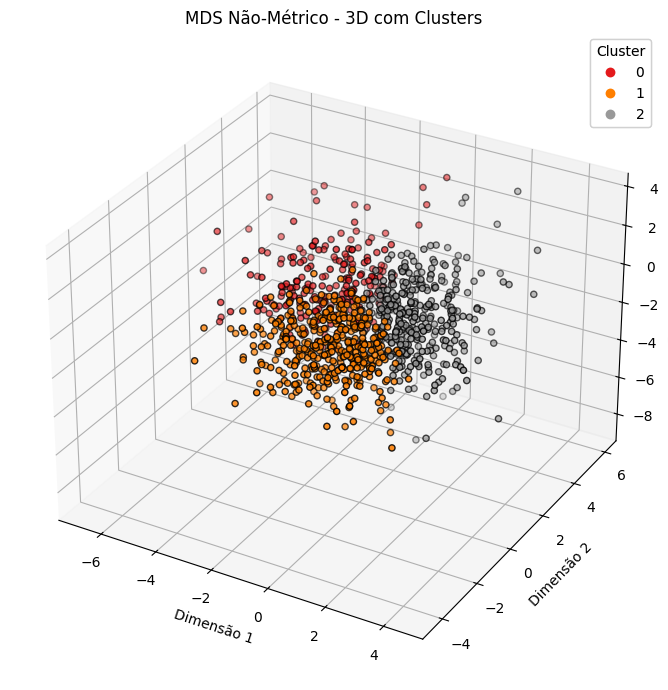

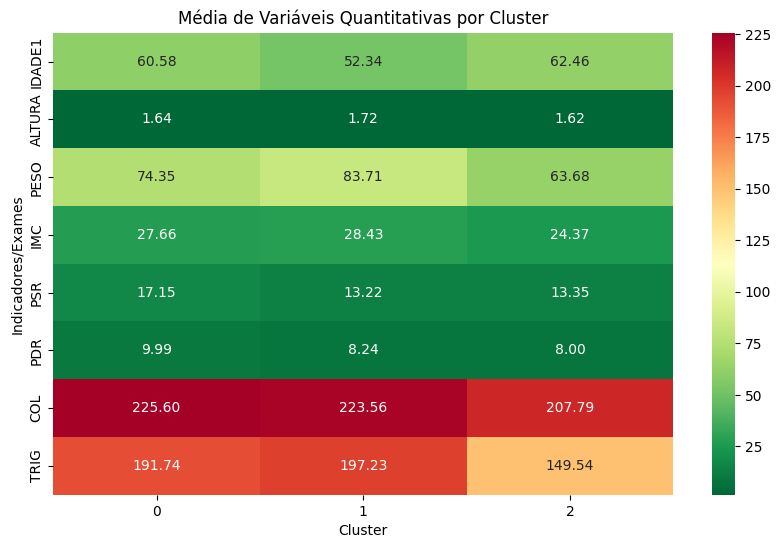

Perfil Numérico dos Clusters:
            IDADE1    ALTURA       PESO        IMC        PSR       PDR  \
Cluster                                                                   
0        60.578680  1.640254  74.345178  27.662284  17.152284  9.994924   
1        52.338624  1.717910  83.708995  28.433651  13.216931  8.238095   
2        62.461728  1.618272  63.676543  24.368395  13.353086  8.002469   

                COL        TRIG  
Cluster                          
0        225.598985  191.736041  
1        223.558201  197.227513  
2        207.787654  149.535802  


In [32]:
# Clustering (K-means)
n_clusters = 3  # você pode mudar dependendo do seu objetivo
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(config_nao_metrica)

# Adicionar clusters ao DataFrame
df_sub['cluster'] = clusters

# Inicializa uma lista para armazenar as distribuições
tabelas_cat = []

for cat in colunas_categoricas:
    # Cria o crosstab normalizado (proporção)
    tab = pd.crosstab(df_sub['cluster'], df_sub[cat], normalize='index').round(2)
    
    # Renomeia as colunas para identificar a variável (ex: SEXO_0, SEXO_1)
    tab.columns = [f"{cat}_{col}" for col in tab.columns]
    tabelas_cat.append(tab)

# Concatena todas as distribuições lateralmente
tabela_final_cat = pd.concat(tabelas_cat, axis=1)

# Exibe a tabela formatada
print("Tabela Consolidada de Variáveis Categóricas por Cluster (%):")
display(tabela_final_cat)

plt.figure(figsize=(16, 6))
sns.heatmap(tabela_final_cat, annot=True, cmap='YlGnBu', cbar=False)
plt.title('Distribuição de Frequência das Categóricas por Cluster (0.0 a 1.0)')
plt.show()

# Plot 3D com cores por cluster
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    config_nao_metrica[:, 0],
    config_nao_metrica[:, 1],
    config_nao_metrica[:, 2],
    c=clusters,
    cmap='Set1',
    edgecolors='k'
)

ax.set_xlabel('Dimensão 1')
ax.set_ylabel('Dimensão 2')
ax.set_zlabel('Dimensão 3')
ax.set_title("MDS Não-Métrico - 3D com Clusters")

# Legenda
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend1)

plt.tight_layout()
plt.show()

# 1. Recalcular os clusters (k=3) usando os dados escalonados (df_quant_scaled)
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(df_quant_scaled) 

# 2. Criar tabela de médias apenas para as quantitativas
# Usamos df_sub[colunas_quantitativas] para garantir que as qualitativas fiquem fora
df_quant_only = df_sub[colunas_quantitativas].copy()
df_quant_only['Cluster'] = labels
perfil_clusters_quant = df_quant_only.groupby('Cluster').mean()

# 3. Gerar o Heatmap focado apenas no perfil biológico/numérico
plt.figure(figsize=(10, 6))
sns.heatmap(perfil_clusters_quant.T, annot=True, cmap='RdYlGn_r', fmt='.2f')

plt.title('Média de Variáveis Quantitativas por Cluster')
plt.ylabel('Indicadores/Exames')
plt.xlabel('Cluster')
plt.show()

# Exibir a tabela limpa no console
print("Perfil Numérico dos Clusters:")
print(perfil_clusters_quant)

Inércia explicada (Dim1, Dim2): [0.20484652 0.18230086]
Valores singulares (Dim1, Dim2): [0.55192956 0.5206714 ]


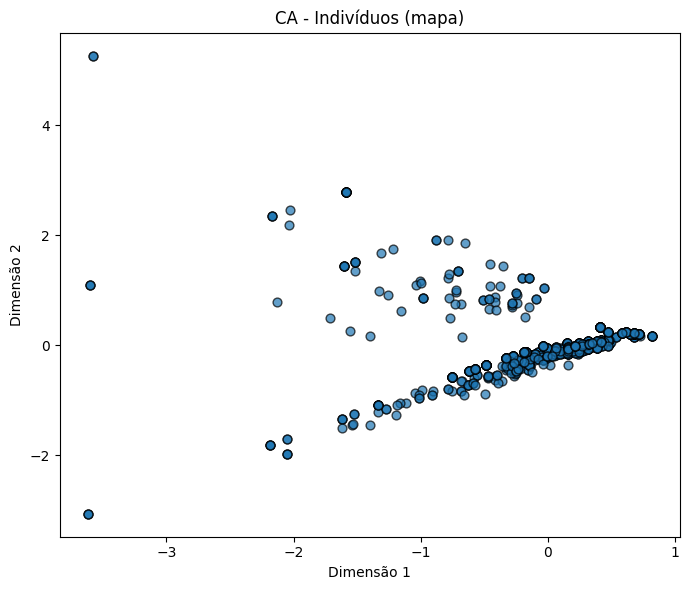

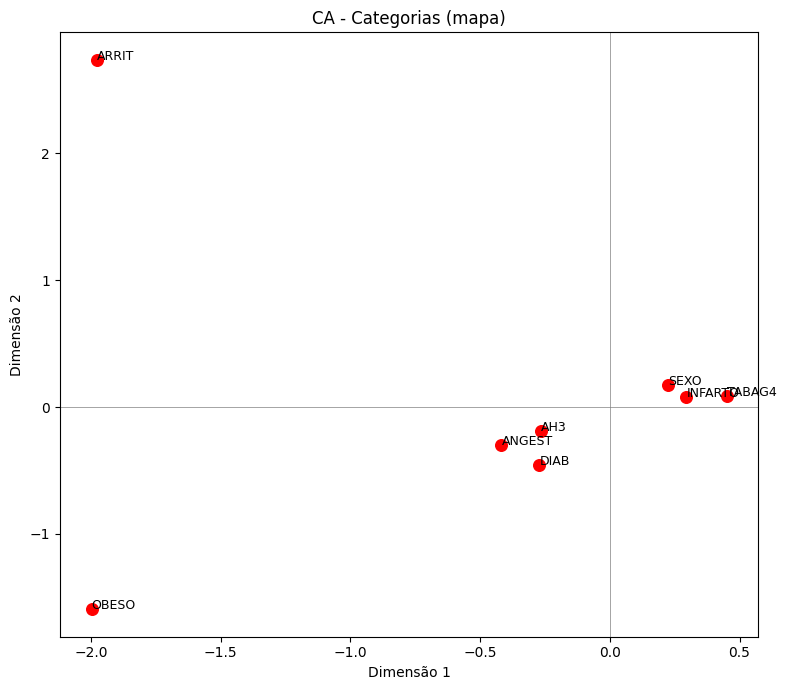

In [20]:
def correspondence_analysis(df_cat, n_components=2, eps=1e-12):
    """
    Implementação de Correspondence Analysis (CA) sem pacotes externos.
    df_cat: DataFrame com variáveis categóricas (cada coluna é uma variável categórica)
    Retorna:
      - row_coords: DataFrame (n_rows x n_components) coordenadas dos indivíduos
      - col_coords: DataFrame (n_columns_dummy x n_components) coordenadas das categorias
      - explained_inertia: array com proporção de inércia explicada por dimensão
      - singular_values: array com valores singulares
    """

    # 1) criar matriz indicador (one-hot) para categorias (cada coluna = uma categoria)
    X = pd.get_dummies(df_cat, drop_first=False).astype(float)
    labels_cols = X.columns.tolist()
    labels_rows = X.index.tolist()

    # 2) contingency-like: soma por linha/coluna
    n = X.values.sum()
    if n <= 0:
        raise ValueError("Matriz vazia / sem observações")

    P = X.values / n                       # matriz de correspondência (frequência relativa)
    r = P.sum(axis=1, keepdims=True)      # marginais linhas (n x 1)
    c = P.sum(axis=0, keepdims=True)      # marginais colunas (1 x m)

    # remover linhas/colunas com massa zero (se houver)
    nonzero_rows = (r.flatten() > eps)
    nonzero_cols = (c.flatten() > eps)
    P = P[nonzero_rows][:, nonzero_cols]
    r = r[nonzero_rows]
    c = c[:, nonzero_cols]
    labels_rows = [labels_rows[i] for i, ok in enumerate(nonzero_rows) if ok]
    labels_cols = [labels_cols[j] for j, ok in enumerate(nonzero_cols) if ok]

    # 3) matriz centrada / padronizada: S = D_r^{-1/2} (P - r c) D_c^{-1/2}
    rcT = r @ c                            # r c^T -> matriz de independência
    S = P - rcT
    Dr_inv_sqrt = np.diag(1.0 / np.sqrt(r.flatten()))
    Dc_inv_sqrt = np.diag(1.0 / np.sqrt(c.flatten()))
    S_std = Dr_inv_sqrt @ S @ Dc_inv_sqrt

    # 4) SVD
    U, s, VT = np.linalg.svd(S_std, full_matrices=False)
    V = VT.T
    # inertia (autovalores) = s^2
    inertia = s**2
    explained_inertia = inertia / inertia.sum()

    # 5) coordenadas principais
    k = min(n_components, U.shape[1])
    # coordenadas das linhas (indivíduos) F = D_r^{-1/2} * U * diag(s)
    F = Dr_inv_sqrt @ (U[:, :k] * s[:k])
    # coordenadas das colunas (categorias) G = D_c^{-1/2} * V * diag(s)
    G = Dc_inv_sqrt @ (V[:, :k] * s[:k])

    # retornar como DataFrames legíveis
    row_coords = pd.DataFrame(F, index=labels_rows, columns=[f"Dim{i+1}" for i in range(k)])
    col_coords = pd.DataFrame(G, index=labels_cols, columns=[f"Dim{i+1}" for i in range(k)])

    return row_coords, col_coords, explained_inertia[:k], s[:k]


df_cat = df[colunas_categoricas].dropna()

row_coords, col_coords, explained_inertia, singular_values = correspondence_analysis(df_cat, n_components=2)

print("Inércia explicada (Dim1, Dim2):", explained_inertia)
print("Valores singulares (Dim1, Dim2):", singular_values)

# ---- Plot: indivíduos (rows) ----
fig, ax = plt.subplots(figsize=(7,6))
ax.scatter(row_coords["Dim1"], row_coords["Dim2"], alpha=0.7, edgecolors='k', s=40)
ax.set_xlabel("Dimensão 1")
ax.set_ylabel("Dimensão 2")
ax.set_title("CA - Indivíduos (mapa)")
plt.tight_layout()
plt.show()

# ---- Plot: categorias (columns) com anotação ----
fig, ax = plt.subplots(figsize=(8,7))
ax.scatter(col_coords["Dim1"], col_coords["Dim2"], c='red', s=70)
for i, txt in enumerate(col_coords.index):
    ax.annotate(txt, (col_coords.iloc[i,0], col_coords.iloc[i,1]), fontsize=9)
ax.axhline(0, color='gray', linewidth=0.5)
ax.axvline(0, color='gray', linewidth=0.5)
ax.set_xlabel("Dimensão 1")
ax.set_ylabel("Dimensão 2")
ax.set_title("CA - Categorias (mapa)")
plt.tight_layout()
plt.show()